In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
from qiskit_aer import AerSimulator
import numpy as np
from numpy.random import Generator, PCG64
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from src.data import DataSource

# Notebook version of Jiri's QRC

In [2]:
# simulator = QasmSimulator()
simulator = AerSimulator()

n_qubits = 5
len_seq = 100 #input length
washout = 10 #washout period
dim_out_qc = 3 #number of qubits to measure
qubits_meas = [*range(dim_out_qc)]
len_test = 20
shots = 1024


def load_input(qc, inp):
    qc.reset([0])
    if inp:
        qc.x([0])
    return qc

def my_circuit_fixed(qc):  #Just somewhat arbitrarily generated circuit from universal gates (p, h, cx)
    qc.h(0)
    qc.p(1.754,0)
    qc.cnot(0,1)
    qc.h(2)
    qc.p(1.154,2)
    qc.p(2.211,1)
    qc.cnot(1,2)
    qc.h(1)
    qc.p(0.754,0)
    qc.p(1.154,1)
    qc.cnot(1,0)
    qc.p(0.884,2)
    return qc

def fake_circuit(qc):
    qc.unitary(obj=np.eye(2**dim_out_qc), qubits=qubits_meas)
    return qc

    
def measure(qc, step):
    qc.measure(0, dim_out_qc*step)
    
    #Here we do a weak measurement
    qc.h([3])               # 1. apply H to get the ancilla in a state |+>
    qc.ry(-0.25,3)           # 2. Slightly rotate along the y axis to get a state sqrt(1/2+e)|0> + sqrt(1/2-e)|1>
    qc.cx(1,3)              # 3. CNOT to change into sqrt(1/2+e)|1> + sqrt(1/2-e)|0>
    qc.measure(3, dim_out_qc*step+1)  # 4. Measure. More likely to get 0 if control qubit was in state |0> and vice versa
    
    
    qc.h([4])
    qc.ry(-0.25,4)
    qc.cx(2,4)
    qc.measure(4,3*step+2)
    return qc
    
    
def reset_ancillas(qc):
    qc.reset(3)
    qc.reset(4)
    return qc
    

In [3]:
jiris_data = False # should give the same result

if jiris_data:
    # Jiris data
    rng = Generator(PCG64(seed=0))
    input_seq = rng.integers(2, size=len_seq) # (len_seq,)
    encoded_input = np.asarray([bool(i) for i in input_seq])
    #target_seq = np.multiply(np.roll(input_seq,1), input_seq) # for product of input and input shifted by 1
    target_seq = np.roll(input_seq, 1) # for input shifted by 1 # (len_seq,)
else:
    # Andreas data
    data = DataSource(x_type='binary', y_type='roll', n_episodes=1, steps=len_seq)
    input_seq = data.xtrain[0]
    encoded_input = np.asarray([True if i>0 else False for i in input_seq])
    target_seq = data.ytrain[0]


In [4]:
#======================Weak=MEASUREMENTS=============
qc = QuantumCircuit(n_qubits, dim_out_qc*len_seq)
for i in range(len_seq):  
    qc = load_input(qc, encoded_input[i])
    qc = my_circuit_fixed(qc)
    qc = measure(qc, i)
    qc = reset_ancillas(qc)

compiled_qc = transpile(qc, simulator)
job = simulator.run(compiled_qc, shots=shots)
result = job.result()

counts = result.get_counts()
measurements = np.array([[int(qubit)*counts[key] for qubit in key] for key in counts.keys()])
mean = np.flip(np.sum(measurements, axis=0) / shots)
out = mean.reshape(len_seq, dim_out_qc) # (len_seq, dim_qc_out)

print('measurements', np.shape(measurements))
print('mean', np.shape(mean), type(mean), mean.dtype)
print('out', np.shape(out), type(out), out.dtype)
# print('target_seq', np.shape(target_seq))

out_train = sm.add_constant(out[washout:-len_test, :])
x_test = sm.add_constant(out[-len_test:, :])
y_train = target_seq[washout:-len_test]
y_train = y_train.reshape((np.shape(y_train)[0], 1))

print('out_train', np.shape(out_train))
# print(out_train)
print('y_train', np.shape(y_train))
# print(y_train)

model = sm.OLS(y_train, out_train)
fit_results = model.fit()
weights = fit_results.params

print('weights', weights)
print("R-squared weak measurements:", fit_results.rsquared)
print("p-value weak measurements:", fit_results.f_pvalue)
###############     PREDICTIONS START HERE

prediction_test = np.dot(x_test, weights)

results_all = sm.add_constant(out)
prediction_all = np.dot(results_all, weights)

measurements (1024, 300)
mean (300,) <class 'numpy.ndarray'> float64
out (100, 3) <class 'numpy.ndarray'> float64
out_train (70, 4)
y_train (70, 1)
weights [-1.60407529 -3.85967602  6.80241884  1.23490875]
R-squared weak measurements: 0.8956137965228101
p-value weak measurements: 2.5622599856267825e-32


In [5]:
# plt.plot(out_train)
# plt.show()

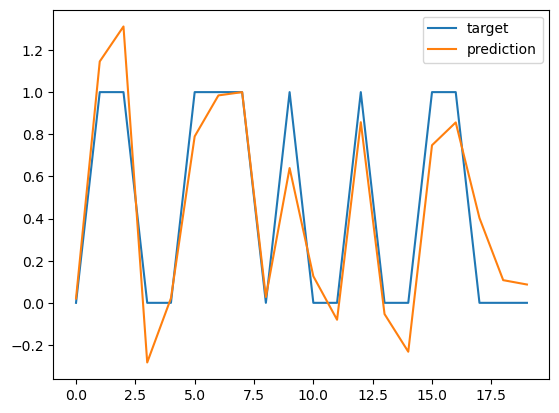

In [6]:
# plt.plot(out, label='out')
# plt.show()

plt.plot(target_seq[-len_test:], label='target')
plt.plot(prediction_test, label='prediction')
plt.legend()
plt.show()

# plt.plot(target_seq, label='target')
# plt.plot(prediction_all, label='prediction')
# plt.legend()
# plt.show()

In [7]:
len_seq = 3
qc = QuantumCircuit(n_qubits, dim_out_qc*len_seq)
for i in range(len_seq):
    qc = fake_circuit(qc)
    qc = measure(qc, i)
    qc = reset_ancillas(qc)
# qc.draw()

In [8]:

# #======================STRONG=MEASUREMENTS============= 
# results_strong_meas=np.zeros((len_seq,3))
# qc = QuantumCircuit(3, 3)

# for j in range(len_seq):
#     for k in range(j+1):
#         load_input(bool(input_seq[k]))
#         my_circuit_fixed()
#         qc.barrier()
#     qc.measure([0,1,2], [0,1,2])
#     compiled_qc = transpile(qc,simulator)
#     job = simulator.run(compiled_qc, shots=1000)
#     result = job.result()
#     counts = result.get_counts()
#     measurements = np.array([[int(qubit)*counts[key] for qubit in key] for key in counts.keys()])
#     mean = np.flip(np.sum(measurements, axis=0)/1000)
#     results_strong_meas[j,:] = mean
#     qc=QuantumCircuit(3,3)


# x = sm.add_constant(results_strong_meas[washout:,:])
# model = sm.OLS(target_seq[washout:], x)
# fit_results_strong = model.fit()
# print("R-squared strong measurements:", fit_results_strong.rsquared)
# p_value_strong=fit_results_strong.f_pvalue
# print("p-value strong measurements:", p_value_strong)

# ###############     PREDICTIONS START HERE

# results_all = sm.add_constant(mean[-len_test:,:])
# prediction = np.dot(results_all, fit_results.params)

# print('prediction', np.shape(prediction))
# print('target', np.shape(target_seq))

# plt.plot(target_seq[-len_test:], label='target')
# plt.plot(prediction, label='prediction')
# plt.legend()
# plt.show()

In [9]:
def weak_measurement_circuit(self, angles):
    """
    Measure ancillas 3, 4 to weakly measure qubits 1,2.
    Hard measure qubit 0.
    """
    self.dim_outqc = 3
    steps = np.shape(angles)[0]
    qc = QuantumCircuit(self.n_qubits, self.dim_outqc*steps)
    for step in range(steps):  
            # add input 
        if step > 0:
            qc.reset(self.q_in)
        for q in range(self.dim_x):
            qc.rx(theta=angles[step, q], qubit=self.q_in[q])
        # circuit fixed
        qc.h(0)
        qc.p(1.754,0)
        qc.cnot(0,1)
        qc.h(2)
        qc.p(1.154,2)
        qc.p(2.211,1)
        qc.cnot(1,2)
        qc.h(1)
        qc.p(0.754,0)
        qc.p(1.154,1)
        qc.cnot(1,0)
        qc.p(0.884,2)
        # measure
        # qc.measure(0, self.dim_outqc*step)
        # Weak measurement
        qc.h([3])               # 1. apply H to get the ancilla in a state |+>
        qc.ry(-0.25,3)           # 2. Slightly rotate along the y axis to get a state sqrt(1/2+e)|0> + sqrt(1/2-e)|1>
        qc.cx(1,3)              # 3. CNOT to change into sqrt(1/2+e)|1> + sqrt(1/2-e)|0>
        # qc.measure(3, self.dim_outqc*step+1)  # 4. Measure. More likely to get 0 if control qubit was in state |0> and vice versa
        #
        qc.h([4])
        qc.ry(-0.25,4)
        qc.cx(2,4)
        # qc.measure(4, self.dim_outqc*step+2)
        qc.measure(self.q_out, [*range(self.dim_outqc*step, self.dim_outqc*(step+1))])
        # reset ancillas
        qc.reset(3)
        qc.reset(4)
    return qc